# INF-495, v0.01, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
## Textbook: Computational Mathematical Modeling, An Integrated Approach Across Scales by Daniela Calvetti and Erkki Somersalo.

# Chapter 8

## 8.1 Markov process and random walk

In [30]:
import numpy as np
import scipy.sparse.linalg as sp
import sympy as sym
from scipy.linalg import toeplitz

import ipywidgets as widgets
from ipywidgets import IntSlider

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()

from scipy.integrate import odeint
from ipywidgets import interact

def plot_matrices_with_values2(ax,M,flag_values=False):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    ax.matshow(M, cmap=cmap)
    if flag_values:
        for i in np.arange(0, N):
            for j in np.arange(0, N):
                # I had to change the order of indices to make it right
                ax.text(i, j, '{:.2f}'.format(M[j,i]), va='center', ha='center', color='r')

In [31]:
ids = np.arange(64) # Making it Python compatible
I = np.reshape(ids,(8,8),order='F')
print(I)
# Defining occupied squares ([row,columns])
occupied = np.array([[2, 3], [5, 5], [6, 2], [6, 3]])-1 # Subtracting one to make it Python compatible!
print(occupied)
for oc in occupied:
    print(I[oc[0],oc[1]])

[[ 0  8 16 24 32 40 48 56]
 [ 1  9 17 25 33 41 49 57]
 [ 2 10 18 26 34 42 50 58]
 [ 3 11 19 27 35 43 51 59]
 [ 4 12 20 28 36 44 52 60]
 [ 5 13 21 29 37 45 53 61]
 [ 6 14 22 30 38 46 54 62]
 [ 7 15 23 31 39 47 55 63]]
[[1 2]
 [4 4]
 [5 1]
 [5 2]]
17
36
13
21


In [32]:
# Defining the peice
piece = 'Knight' # 'King' or 'Knight'
if piece == 'King':
    # Squares relative to the current one reached by the King
    Mask = np.zeros((8,2))
    k=0
    piece_range=[-1,0,1]
    for i in piece_range:
        for j in piece_range:
            if not ((i==0) and (j==0)):
                Mask[k,0]=i
                Mask[k,1]=j
                k=k+1
    print(Mask)
elif piece == 'Knight':
    # Squares relative to the current one reached by the Knight
    Mask = np.zeros((8,2))
    k=0
    piece_range=[-2,-1,0,1,2]
    for i in [-2,-1,0,1,2]:
        for j in [-2,-1,0,1,2]:
            if np.linalg.norm([i,j],ord=1)==3:
                Mask[k,0]=i
                Mask[k,1]=j
                k=k+1
    print(Mask)
else:
    print('Wrong piece!')

[[-2. -1.]
 [-2.  1.]
 [-1. -2.]
 [-1.  2.]
 [ 1. -2.]
 [ 1.  2.]
 [ 2. -1.]
 [ 2.  1.]]


In [33]:
M = np.zeros((64,64))
# Scan through all starting squares
# find all possible destinations
for n in np.arange(8):
    for m in np.arange(8):
        k=I[n,m] # Index to current square
        # Find possible destination square using the mask
        P = np.array([n, m])+Mask
        # Discard occupied squares
        P_tmp=[]
        for p in P:
            flag=0
            for oc_sq in occupied:
                if abs(oc_sq[0]-p[0])+abs(oc_sq[1]-p[1])<1e-10:
                    flag=1
            if flag==0:
                P_tmp.append(p)
        P=np.array(P_tmp,dtype=int)
        # Discarding squares outside the board
        P_tmp=[]
        for p in P:
            if p[0]>=0 and p[0]<=7 and p[1]>=0 and p[1]<=7:
                P_tmp.append(p)
        P=np.array(P_tmp,dtype=int)
        nP = P.shape[0] # number of possible destinations
        # Fill in the probabilities
        for p in P:
            Ip = I[p[0],p[1]] # Destination index
            M[Ip,k] = 1/nP # Moving probability

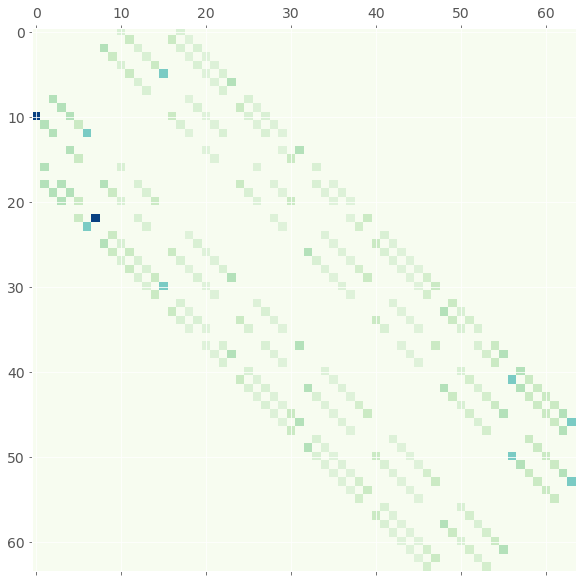

In [34]:
fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
plot_matrices_with_values2(ax1,M,False)

## First algorithm: Random walk. Now I added the plot of the resulting probabilities, it is interesting to observe the evolution from the beginning. Compare with the other two outcomes.

In [35]:
def plot_random_walk_output(nsteps=1):
    np.random.seed(0)
    # nsteps = 100000
    prev   = I[1,2]
    ncounts = np.zeros(64)
    squares_ids = [prev]
    for n in np.arange(nsteps):
        # Random draw using the column M[:,prev]
        next_step = np.random.choice(np.arange(64),p=M[:,prev])
        ncounts[next_step] = ncounts[next_step] + 1
        prev = next_step
        squares_ids.append(next_step)
    fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
    plot_matrices_with_values2(ax1,np.log10(np.reshape(ncounts/np.sum(ncounts),(8,8),order='F')),True)
    # print(ncounts)
    # print(squares_ids)
    # print(I)
interact(plot_random_walk_output,nsteps=(0,500000,1))

interactive(children=(IntSlider(value=1, description='nsteps', max=500000), Output()), _dom_classes=('widget-i…

<function __main__.plot_random_walk_output(nsteps=1)>

## Second algorithm: Power iteration. Warning: For the case of the Knight, this algorithm shows an interesting behavior and that seems to be related there are two eigenvalues with the magnitud equal to 1, one of the is actually equal to 1 but the other is equally to -1. This does not happen for the case of the King.

In [37]:
def plot_P_n(nj, I, M):
    # Defining initial distribution
    (i0,j0)=(0,1)
    pcurr = np.zeros(64)
    pcurr[I[i0,j0]] = 1
    for j in np.arange(nj):
        pcurr = np.dot(M,pcurr)
    pcurrM = np.reshape(pcurr,(8,8),order='F')
    fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
    plot_matrices_with_values2(ax1,np.log10(pcurrM),True)
    # print(pcurr)
interact(lambda nj=0: plot_P_n(nj, I=I, M=M), nj = (0,2000,1))

interactive(children=(IntSlider(value=0, description='nj', max=2000), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(nj=0)>

## Third algorithm: Eigenvalues and eigenvectors. We need to look for the eigenvector associated to the eigenvalue equal to 1.

In [38]:
w, v = np.linalg.eig(M)

In [10]:
w

array([-1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
       -7.50632749e-01+0.00000000e+00j, -7.27823791e-01+0.00000000e+00j,
       -7.01486703e-01+0.00000000e+00j,  7.50632749e-01+0.00000000e+00j,
        7.27823791e-01+0.00000000e+00j,  7.01486703e-01+0.00000000e+00j,
       -6.48633862e-01+0.00000000e+00j,  6.48633862e-01+0.00000000e+00j,
       -6.09881975e-01+0.00000000e+00j, -5.81559313e-01+0.00000000e+00j,
       -5.60397014e-01+0.00000000e+00j, -5.50942218e-01+0.00000000e+00j,
       -5.25497291e-01+0.00000000e+00j, -4.93732549e-01+0.00000000e+00j,
       -4.82696191e-01+0.00000000e+00j, -4.34951590e-01+0.00000000e+00j,
       -3.99042432e-01+0.00000000e+00j, -3.75078686e-01+0.00000000e+00j,
       -3.65281851e-01+0.00000000e+00j, -3.37548113e-01+0.00000000e+00j,
       -3.14489772e-01+0.00000000e+00j, -2.90154101e-01+0.00000000e+00j,
       -2.79989305e-01+0.00000000e+00j, -2.53118528e-01+0.00000000e+00j,
       -2.57620679e-01+0.00000000e+00j, -2.20992118

In [41]:
v0=np.real(v[:,0])/np.sum(np.real(v[:,0]))
print(v0)

[-3.21099073e+13  9.63297220e+13 -9.63297220e+13  9.63297220e+13
 -9.63297220e+13  1.28439629e+14 -6.42198147e+13  3.21099073e+13
  9.63297220e+13 -1.28439629e+14  1.92659444e+14 -1.28439629e+14
  1.92659444e+14 -0.00000000e+00  1.28439629e+14 -6.42198147e+13
 -1.28439629e+14 -0.00000000e+00 -2.56879259e+14  1.92659444e+14
 -2.56879259e+14 -0.00000000e+00 -1.92659444e+14  9.63297220e+13
  1.28439629e+14 -1.92659444e+14  2.24769351e+14 -1.92659444e+14
  2.24769351e+14 -2.56879259e+14  1.28439629e+14 -9.63297220e+13
 -9.63297220e+13  1.92659444e+14 -2.24769351e+14  2.56879259e+14
 -0.00000000e+00  2.56879259e+14 -1.60549537e+14  1.28439629e+14
  1.28439629e+14 -1.92659444e+14  2.24769351e+14 -2.56879259e+14
  2.56879259e+14 -2.56879259e+14  1.60549537e+14 -1.28439629e+14
 -9.63297220e+13  1.28439629e+14 -1.92659444e+14  1.60549537e+14
 -1.92659444e+14  1.60549537e+14 -1.28439629e+14  9.63297220e+13
  6.42198147e+13 -9.63297220e+13  1.28439629e+14 -1.28439629e+14
  1.28439629e+14 -1.28439

In [42]:
v1=np.real(v[:,1])/np.sum(np.real(v[:,1]))
print(v1)

[ 0.0035461   0.0106383   0.0106383   0.0106383   0.0106383   0.0141844
  0.0070922   0.0035461   0.0106383   0.0141844   0.0212766   0.0141844
  0.0212766  -0.          0.0141844   0.0070922   0.0141844  -0.
  0.02836879  0.0212766   0.02836879 -0.          0.0212766   0.0106383
  0.0141844   0.0212766   0.0248227   0.0212766   0.0248227   0.02836879
  0.0141844   0.0106383   0.0106383   0.0212766   0.0248227   0.02836879
 -0.          0.02836879  0.0177305   0.0141844   0.0141844   0.0212766
  0.0248227   0.02836879  0.02836879  0.02836879  0.0177305   0.0141844
  0.0106383   0.0141844   0.0212766   0.0177305   0.0212766   0.0177305
  0.0141844   0.0106383   0.0070922   0.0106383   0.0141844   0.0141844
  0.0141844   0.0141844   0.0106383   0.0070922 ]


/Users/claudio/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


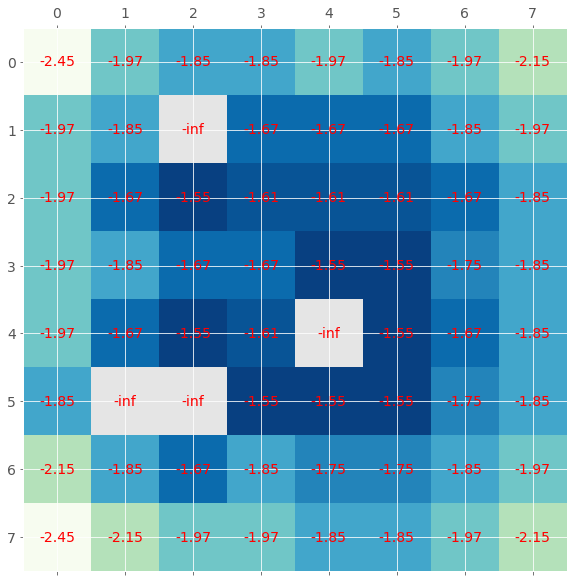

In [47]:
if piece == 'King':
    v_selected = v0
elif piece == 'Knight':
    v_selected = v1
else:
    print('Wrong piece!')
    v_selected=np.full((64),np.nan)
fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
plot_matrices_with_values2(ax1,np.log10(np.reshape(np.real(v_selected),(8,8),order='F')),True)

# 8.2 Stochastic predator-prey model

In [ ]:
def plot_S_Pred_Prey(seed=0):
    Nj       = 200 # number of X adult pair at t = t(j)
    Mj       = 50  # number of Y adult pair at t = t(j)
    p_mean   = 10  # mean number of X offsprings/adult pair
    p_std    = 3   # std of the number of the X offspring/adult pair
    beta     = 0.3 # Survival probability of X in the absence of Y
    Mstar    = 50  # number of Y that halves the survival prob. of X
    q_mean   = 4   # mean number of Y offspring/adult pair
    q_std    = 2   # std of the number of the Y offsrping/adult pair
    gamma    = 0.6 # Survival prob. of Y in adundance of X
    Nstar    = 400 # Number of X pairs at which the survival prob. of Y is halved

    nrounds  = 40  # Number of generations allowed

    N = np.full(nrounds,np.nan)
    N[0] = Nj
    M = np.full(nrounds,np.nan)
    M[0] = Mj
    Surv = np.full((nrounds-1,2),np.nan)

    np.random.seed(seed)

    for j in np.arange(1,nrounds):
        # Draw the number of offsprings of species X
        Pj = Nj*p_mean+np.sqrt(Nj)*p_std*np.random.randn()
        # Survival probability of the offspring of species X
        s = beta/(1+(Mj/Mstar)**2)
        Nj = s*Pj+np.sqrt(s*Pj*(1-s))*np.random.randn()
        N[j] = 0.5*Nj
        # Draw the number of offsprings of species Y
        Qj = Mj*q_mean+np.sqrt(Mj)*q_std*np.random.randn()
        # Survival probability of the offspring of species Y
        r = gamma*(1-1/(1+(Nj/Nstar)**2))
        Mj = r*Qj+np.sqrt(r*Qj*(1-r))*np.random.randn()
        M[j] = 0.5*Mj
        # Saving the survival probabilities for later analysis
        Surv[j-1,:]=[s,r]

    s=Surv[:,0]
    r=Surv[:,1]
    
    smean = np.sum(s)/(nrounds-1)
    rmean = np.sum(r)/(nrounds-1)
    Surv_c = Surv-np.array([smean,rmean])
    covSurv = np.dot(Surv_c.T,Surv_c)/(nrounds-1)
    corrcoeff = covSurv[0,1]/np.sqrt(covSurv[0,0]*covSurv[1,1])
        
    fig,  ((ax1,ax2),(ax3,ax4))   = plt.subplots(2, 2, figsize=(10,10))
    
    ax4.plot(N,'r.-')
    ax4.plot(M,'b.-')
    ax4.grid(True)
    
    s=Surv[:,0]
    r=Surv[:,1]
    ax1.plot(s,r,'.')
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_xlabel(r'$s_i$')
    ax1.set_ylabel(r'$r_i$')
    ax1.text(0.5, 0.2, 'c={:.5f}'.format(corrcoeff), va='center', ha='center', color='k')
    
    ax2.hist(r,orientation='horizontal')
    ax2.set_ylim(0,1)
    
    ax3.hist(s)
    ax3.set_xlim(0,1)
    
    plt.show()
interact(plot_S_Pred_Prey,seed=(0,100,1))